In [50]:
import random
import numpy as np
import pandas as pd
import torch
import config as cfg
from data_loader import get_data_loader
from utility.survival import make_time_bins
from utility.survival import preprocess_data
from pathlib import Path
import joblib

matplotlib_style = 'default'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
plt.rcParams.update({'axes.labelsize': 'large',
                     'axes.titlesize': 'large',
                     'font.size': 14.0,
                     'text.usetex': True,
                     'text.latex.preamble': r'\usepackage{amsfonts} \usepackage{bm}'})

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

# Setup precision
dtype = torch.float32
torch.set_default_dtype(dtype)

# Setup device
device = torch.device('cpu')

# Load data
dl = get_data_loader("proact_me")
dl = dl.load_data()
train_dict, valid_dict, test_dict = dl.split_data(train_size=0.7, valid_size=0.1,
                                                  test_size=0.2, random_state=0)
n_events = dl.n_events

# Preprocess data
cat_features = dl.cat_features
num_features = dl.num_features
trajectories = dl.trajectories
event_cols = [f'e{i+1}' for i in range(n_events)]
time_cols = [f't{i+1}' for i in range(n_events)]
X_train = pd.DataFrame(train_dict['X'], columns=dl.columns)
X_valid = pd.DataFrame(valid_dict['X'], columns=dl.columns)
X_test = pd.DataFrame(test_dict['X'], columns=dl.columns)
X_train, X_valid, X_test= preprocess_data(X_train, X_valid, X_test, cat_features,
                                        num_features, as_array=True)
train_dict['X'] = torch.tensor(X_train, device=device, dtype=dtype)
train_dict['E'] = torch.tensor(train_dict['E'], device=device, dtype=torch.int32)
train_dict['T'] = torch.tensor(train_dict['T'], device=device, dtype=torch.float32)
valid_dict['X'] = torch.tensor(X_valid, device=device, dtype=dtype)
valid_dict['E'] = torch.tensor(valid_dict['E'], device=device, dtype=torch.int32)
valid_dict['T'] = torch.tensor(valid_dict['T'], device=device, dtype=torch.float32)
test_dict['X'] = torch.tensor(X_test, device=device, dtype=dtype)
test_dict['E'] = torch.tensor(test_dict['E'], device=device, dtype=torch.int32)
test_dict['T'] = torch.tensor(test_dict['T'], device=device, dtype=torch.float32)

n_samples = train_dict['X'].shape[0]
n_features = train_dict['X'].shape[1]

# Make time bins
time_bins = make_time_bins(train_dict['T'].cpu(), event=None, dtype=dtype).to(device)
time_bins = torch.cat((torch.tensor([0]).to(device), time_bins))

In [31]:
trained_models = []
for n_dists in [1, 3, 5, 7]:
    path = Path.joinpath(cfg.MODELS_DIR, f"mensa_proact_me_{n_dists}_dists.pkl")
    model = joblib.load(path)
    model.model.to(device)
    trained_models.append(model)

In [32]:
trained_model_preds = []
for model in trained_models:
    all_preds = []
    for i in range(n_events):
        model_preds = model.predict(test_dict['X'].to(device), time_bins, risk=i+1)
        model_preds = pd.DataFrame(model_preds, columns=time_bins.cpu().numpy())
        all_preds.append(model_preds)
    trained_model_preds.append(all_preds)

In [33]:
# Evaluate each model
from SurvivalEVAL.Evaluator import LifelinesEvaluator

for trained_model in trained_models:
    ci, ibs, mae, d_calib = list(), list(), list(), 0
    for i in range(n_events):
        model_preds = trained_model.predict(train_dict['X'].to(device), time_bins, risk=i+1)
        model_preds = pd.DataFrame(model_preds, columns=time_bins.cpu().numpy())
        
        n_train_samples = len(train_dict['X'])
        n_test_samples= len(test_dict['X'])
        y_train_time = train_dict['T'][:,i]
        y_train_event = train_dict['E'][:,i]
        y_test_time = test_dict['T'][:,i]
        y_test_event = test_dict['E'][:,i]
        
        lifelines_eval = LifelinesEvaluator(model_preds.T, y_train_time, y_train_event,
                                            y_train_time, y_train_event)
        
        ci_event = lifelines_eval.concordance()[0]
        ibs_event = lifelines_eval.integrated_brier_score()
        mae_event = lifelines_eval.mae(method="Margin")
        d_calib_event = 1 if (lifelines_eval.d_calibration()[0] > 0.05) else 0
        
        ci.append(ci_event)
        ibs.append(ibs_event)
        mae.append(mae_event)
        d_calib += d_calib_event
        
    print(f"{np.mean(ci)} - {np.mean(ibs)} - {np.mean(mae)} - {d_calib}")

0.7324945409096277 - 0.1576860599942233 - 183.58685930459825 - 3
0.7311695229311462 - 0.15501993995301594 - 121.23571409493312 - 3
0.7287777485388667 - 0.15692813240087766 - 121.65049024394716 - 3
0.7244314090805267 - 0.159220211954401 - 117.50663979610788 - 4


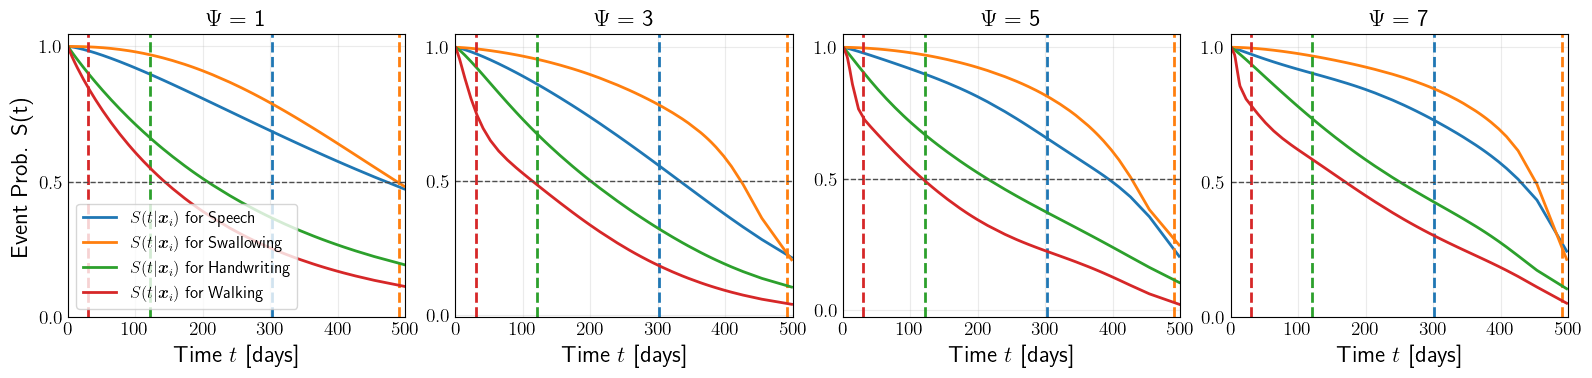

In [34]:
import matplotlib.pyplot as plt

from SurvivalEVAL import LifelinesEvaluator
from SurvivalEVAL.Evaluations.util import predict_median_survival_time

# Configure plot dimensions
fig, axes = plt.subplots(1, 4, figsize=(16, 4), constrained_layout=True)

axes = axes.flatten()  # Flatten axes for easy indexing

event_names = ['Speech', 'Swallowing', 'Handwriting', 'Walking']
psi_values = {0: 1, 1: 3, 2: 5, 3:7}

sample_idx = 100
for i, trained_model_pred in enumerate(trained_model_preds):
    ax = axes[i]  # Select the appropriate subplot for this model

    # Add title
    ax.set_title(r"$\Psi = $" + f" {psi_values[i]}")

    # Get actual/predicted survival times for each model
    event_pred_outputs = []
    event_sample_tte, event_observed, event_pred_survival_times = [], [], []
    for event_id in range(n_events):
        sample_tte = test_dict['T'][sample_idx, event_id]
        is_observed = (test_dict['E'][sample_idx, event_id] == 1)
        sample_pred_surv_times = trained_model_pred[event_id].iloc[sample_idx].to_numpy()
        lifelines_eval = LifelinesEvaluator(trained_model_pred[event_id].T,
                                            test_dict['T'][event_id],
                                            test_dict['E'][event_id],
                                            train_dict['T'][event_id],
                                            train_dict['E'][event_id])
        median_survival_time = lifelines_eval.predict_time_from_curve(predict_median_survival_time)
        pred_survival_time = median_survival_time[sample_idx]
        event_pred_outputs.append(sample_pred_surv_times)
        event_sample_tte.append(sample_tte)
        event_observed.append(is_observed)
        event_pred_survival_times.append(pred_survival_time)
    
    # Plot on the specific subplot
    vertical_line_handles = []
    vertical_line_labels = []

    for j, (event_name, mean_output, sample_tte, is_observed) in \
        enumerate(zip(event_names, event_pred_outputs, event_sample_tte, event_observed)):
            
        # Plot the survival curves
        ax.plot(time_bins, mean_output, linewidth=2,
                label=r"$S(t|\bm{x}_{i})$" + f" for {event_name}", color=f"C{j}")
    
        # Plot vertical lines if the event is observed
        if is_observed:
            #jitter = np.random.uniform(-5, 5)
            vline = ax.axvline(x=int(sample_tte), linestyle="dashed", linewidth=2, color=f"C{j}")
            # Store the vertical line handle and label separately
            vertical_line_handles.append(vline)
    
    # Add a horizontal dashed line at y=0.5
    ax.axhline(y=0.5, linestyle="dashed", linewidth=1, color="#4D4D4D")

    # Add labels and grid
    if i == 0:  # Add \( y \)-label only for the first column
        ax.set_ylabel("Event Prob. S(t)")
    ax.set_xlabel("Time $t$ [days]")
    ax.set_xlim((0, 500))
    ax.grid(True, alpha=0.25)

    # Set custom y-ticks to 1, 0.5, and 0
    ax.set_yticks([1, 0.5, 0])

    ax.tick_params(axis='y', which='both', length=0)
    ax.tick_params(axis='x', which='both', length=0)

    if i == 0:  # Add the legend only for the first subplot
        ax.legend(fontsize=12)
    
# Adjust layout
plt.tight_layout()

# Save the plot (optional)<
plt.savefig(f"{cfg.PLOTS_DIR}/proact_isd_mixtures.pdf", format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

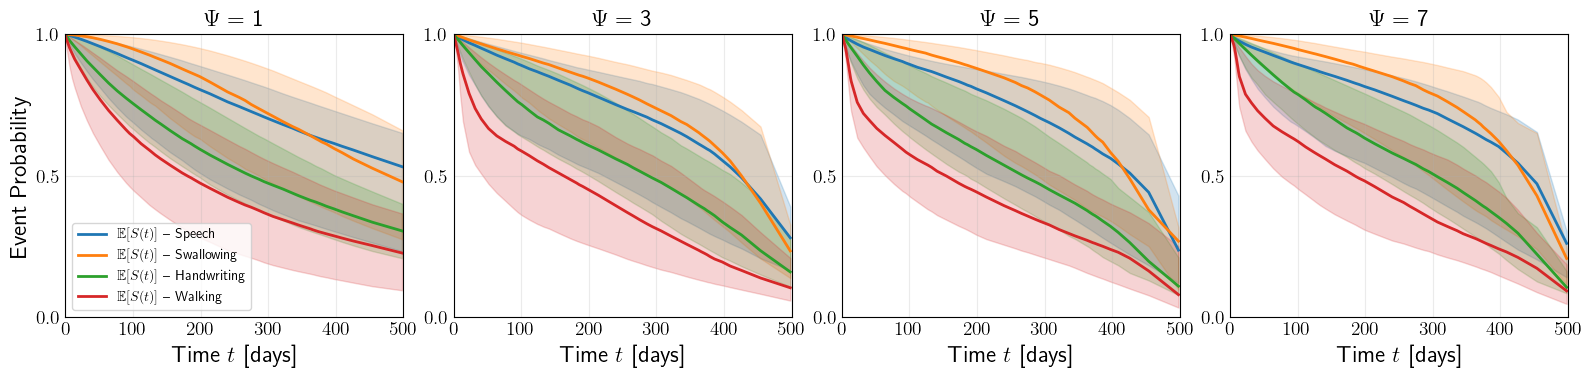

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Configure plot dimensions
fig, axes = plt.subplots(1, 4, figsize=(16, 4), constrained_layout=True)
axes = axes.flatten()

event_names = ['Speech', 'Swallowing', 'Handwriting', 'Walking']
psi_values = {0: 1, 1: 3, 2: 5, 3: 7}

for i, trained_model_pred in enumerate(trained_model_preds):
    ax = axes[i]
    ax.set_title(r"$\Psi = $" + f" {psi_values[i]}")

    for event_id, event_name in enumerate(event_names):
        # Each trained_model_pred[event_id] is expected to be an (N x T) DataFrame
        surv_curves = trained_model_pred[event_id].to_numpy()  # (N, T)
        time_axis = trained_model_pred[event_id].columns.to_numpy()

        # Compute percentiles across patients
        median_curve = np.percentile(surv_curves, 50, axis=0)
        lower_curve = np.percentile(surv_curves, 20, axis=0)
        upper_curve = np.percentile(surv_curves, 80, axis=0)

        # Plot population median survival curve
        #ax.plot(time_axis, median_curve, color=f"C{event_id}",
         #       label=rf"$\mathbb{{E}}[S(t)]$ – {event_name}",
         #       linewidth=2)

        # Fill between 10–90 percentile bands
        ax.fill_between(time_axis, lower_curve, upper_curve,
                        color=f"C{event_id}", alpha=0.20)
        ax.plot(time_axis, median_curve, color=f"C{event_id}",
                label=rf"$\mathbb{{E}}[S(t)]$ – {event_name}", linewidth=2)

    # Axes formatting
    if i == 0:
        ax.set_ylabel("Event Probability")
    ax.set_xlabel("Time $t$ [days]")
    ax.set_xlim((0, 500))
    ax.set_ylim((0, 1.0))
    ax.grid(True, alpha=0.25)
    ax.set_yticks([1, 0.5, 0])
    ax.tick_params(axis='y', which='both', length=0)
    ax.tick_params(axis='x', which='both', length=0)
    if i == 0:
        ax.legend(fontsize=10)

plt.tight_layout()
plt.savefig(f"{cfg.PLOTS_DIR}/population_isd_mixtures.pdf", format='pdf', bbox_inches='tight')
plt.show()

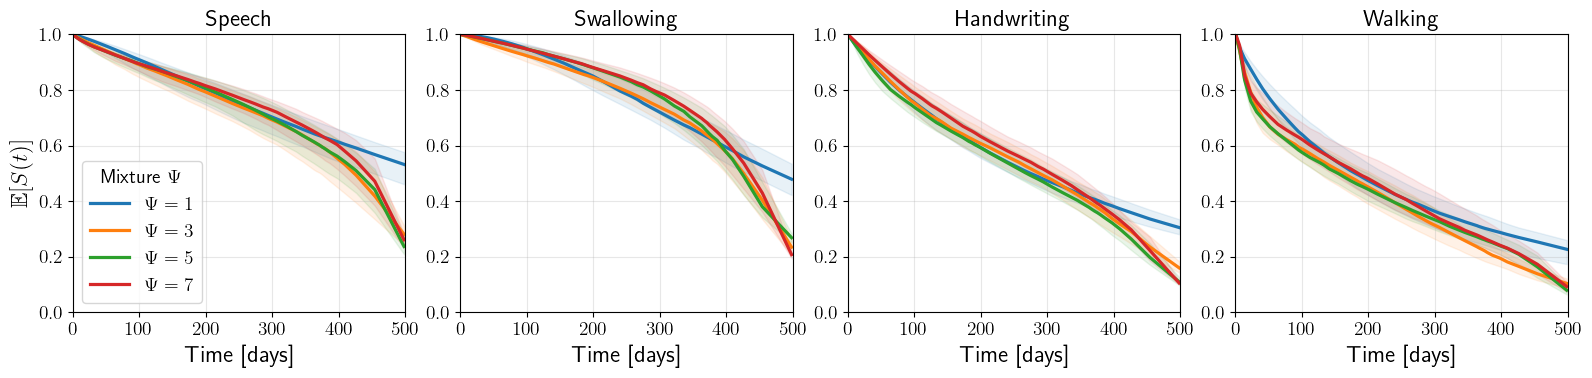

In [36]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), constrained_layout=True)
for e, event_name in enumerate(event_names):
    ax = axes[e]
    ax.set_title(event_name)
    for i, preds in enumerate(trained_model_preds):
        S = preds[e].to_numpy()
        t = preds[e].columns.to_numpy()
        med = np.percentile(S, 50, axis=0)
        lo  = np.percentile(S, 40, axis=0)
        hi  = np.percentile(S, 60, axis=0)
        ax.fill_between(t, lo, hi, color=f"C{i}", alpha=0.10)
        ax.plot(t, med, color=f"C{i}", lw=2.3,
                label=rf"$\Psi={psi_values[i]}$")
    if e == 0:
        ax.set_ylabel(r"$\mathbb{E}[S(t)]$")
    ax.set_xlabel("Time [days]")
    ax.set_xlim(0, 500)
    ax.set_ylim(0, 1)
    ax.grid(alpha=0.3)
axes[0].legend(title=r"Mixture $\Psi$")
plt.tight_layout()
plt.show()

In [37]:
from SurvivalEVAL.Evaluator import LifelinesEvaluator
import pandas as pd
import numpy as np

event_names = ['Speech', 'Swallowing', 'Handwriting', 'Walking']
psi_values = {0: 1, 1: 3, 2: 5, 3: 7}

metrics_df = []

for i, trained_model in enumerate(trained_models):
    ci, ibs, mae, d_calib = [], [], [], []
    for e in range(len(event_names)):
        preds = trained_model.predict(train_dict['X'].to(device), time_bins, risk=e+1)
        preds = pd.DataFrame(preds, columns=time_bins.cpu().numpy())
        y_train_time, y_train_event = train_dict['T'][:, e], train_dict['E'][:, e]
        y_test_time, y_test_event = test_dict['T'][:, e], test_dict['E'][:, e]

        lifelines_eval = LifelinesEvaluator(preds.T, y_train_time, y_train_event,
                                            y_test_time, y_test_event)

        ci_event = lifelines_eval.concordance()[0]
        ibs_event = lifelines_eval.integrated_brier_score()
        mae_event = lifelines_eval.mae(method="Margin")
        d_calib_event = 1 if (lifelines_eval.d_calibration()[0] > 0.05) else 0

        ci.append(ci_event)
        ibs.append(ibs_event)
        mae.append(mae_event)
        d_calib.append(d_calib_event)

        metrics_df.append({
            "Psi": psi_values[i],
            "Event": event_names[e],
            "CI": ci_event,
            "IBS": ibs_event,
            "MAE": mae_event,
            "D_calib": d_calib_event
        })

metrics_df = pd.DataFrame(metrics_df)

In [38]:
metrics_summary = (
    metrics_df
    .groupby(["Psi", "Event"])
    .agg({"CI": "mean", "IBS": "mean", "MAE": "mean"})
    .reset_index()
)

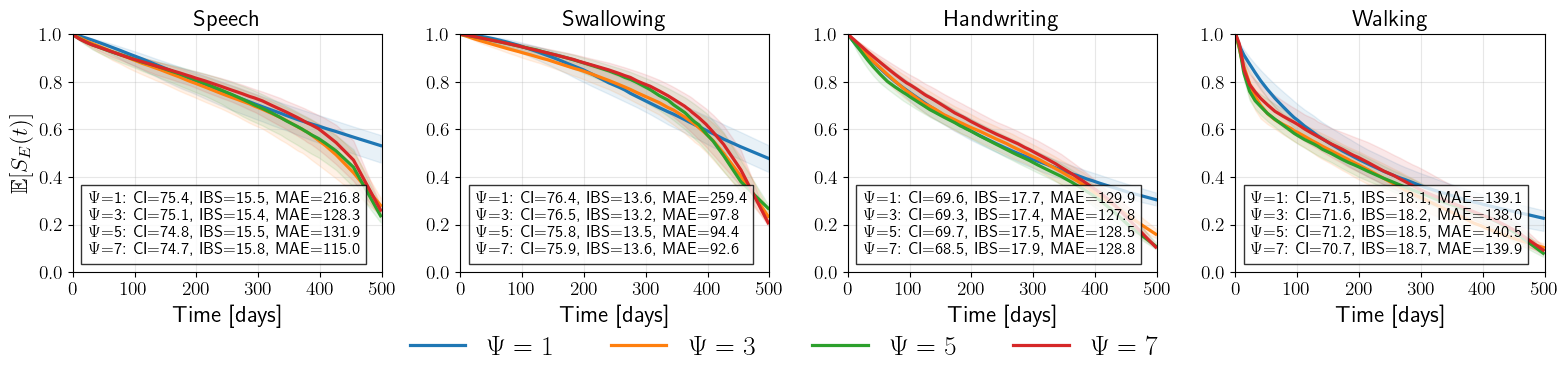

In [73]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

fig, axes = plt.subplots(1, 4, figsize=(16, 4), constrained_layout=True)

for e, event_name in enumerate(event_names):
    ax = axes[e]
    ax.set_title(event_name)
    for i, preds in enumerate(trained_model_preds):
        S = preds[e].to_numpy()
        t = preds[e].columns.to_numpy()
        med = np.percentile(S, 50, axis=0)
        lo  = np.percentile(S, 40, axis=0)
        hi  = np.percentile(S, 60, axis=0)
        ax.fill_between(t, lo, hi, color=f"C{i}", alpha=0.10)
        ax.plot(t, med, color=f"C{i}", lw=2.3,
                label=rf"$\Psi={psi_values[i]}$")
    if e == 0:
        ax.set_ylabel(r"$\mathbb{E}[S_E(t)]$")
    ax.set_xlabel("Time [days]")
    ax.set_xlim(0, 500)
    ax.set_ylim(0, 1)
    ax.grid(alpha=0.3)

    # --- Metrics box (bottom-left) with decimals for CI/IBS ---
    sub = metrics_summary[metrics_summary["Event"] == event_name]
    lines = [
        rf"$\Psi$={row.Psi}: CI={row.CI*100:.1f}, IBS={row.IBS*100:.1f}, MAE={row.MAE:.1f}"
        for _, row in sub.iterrows()
    ]
    txt = "\n".join(lines)
    box = AnchoredText(txt, loc="lower left",
                       prop=dict(size=12, family="sans-serif"),
                       frameon=True)
    box.patch.set_alpha(0.8)
    ax.add_artist(box)

# --- Shared legend below all subplots ---
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center",
           ncol=4, title="", fontsize=20, frameon=False)

plt.subplots_adjust(bottom=0.22)
plt.tight_layout(rect=[0, 0.1, 1, 1])

plt.savefig(f"{cfg.PLOTS_DIR}/proact_pop_survival.pdf", bbox_inches='tight')
plt.show()